In [1]:
import sys
sys.path.append('/home/paperspace/repos/fastai')
import torch

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

from sklearn.metrics import fbeta_score
import warnings

In [2]:
PATH = '/home/paperspace/data/amazon-rainforest/'

In [3]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]

In [4]:
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

In [5]:
metrics = [f2]

In [6]:
def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]

In [7]:
def get_data(path, tfms,bs,  n, cv_idx):
    val_idxs = get_cv_idxs(n, cv_idx)
    return ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms,
                                 suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [8]:
def get_data_zoom(f_model, path, sz, bs, n, cv_idx):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return get_data(path, tfms, bs, n, cv_idx)

In [9]:
def get_data_pad(f_model, path, sz, bs, n, cv_idx):
    transforms_pt = [RandomRotateZoom(9, 0.18, 0.1), RandomLighting(0.05, 0.1), RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_pt, pad=sz//12)
    return get_data(path, tfms, bs, n, cv_idx)

In [10]:
f_model = resnet34

In [11]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

The set of images requires a different type of data augmentation than side-on. For one, vertical flips are allows because we don't expect that orientation axis to impact the classifications. This uses 8 flips of 90, 180, 270 and 0 degrees. There are also rotation, zoom, contrast and brightness adjustments.

Note:  

`data.val_ds` returns a single item  
`data.val_d` returns a generator which processes a mini-batch of images.

In [12]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')


In [13]:
os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('cache/planet/tmp', exist_ok=True)

In [23]:
data = get_data(256)

In [24]:
x,y = next(iter(data.val_dl))

In [25]:
y


    1     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [26]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

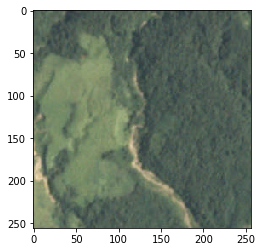

In [27]:
# Look at one of the images:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

### Resize the data from 256 down to 64x64

The pre-trained ImageNet weights aren't useful for satellite images, because they have a different structure than the side-on images it assumes.

Resizing images takes a center crop and saves preprocessing time.

In [28]:
sz = 64
data = get_data(sz)

In [29]:
# need to extract test files archive before running this:
data = data.resize(int(sz*1.3), 'tmp')

### Training:

In [30]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [31]:
# show some information about the layers in the model:
list(learn.summary().items())[:5]

[('Conv2d-1',
  OrderedDict([('input_shape', [-1, 3, 64, 64]),
               ('output_shape', [-1, 64, 32, 32]),
               ('trainable', False),
               ('nb_params', 9408)])),
 ('BatchNorm2d-2',
  OrderedDict([('input_shape', [-1, 64, 32, 32]),
               ('output_shape', [-1, 64, 32, 32]),
               ('trainable', False),
               ('nb_params', 128)])),
 ('ReLU-3',
  OrderedDict([('input_shape', [-1, 64, 32, 32]),
               ('output_shape', [-1, 64, 32, 32]),
               ('nb_params', 0)])),
 ('MaxPool2d-4',
  OrderedDict([('input_shape', [-1, 64, 32, 32]),
               ('output_shape', [-1, 64, 16, 16]),
               ('nb_params', 0)])),
 ('Conv2d-5',
  OrderedDict([('input_shape', [-1, 64, 16, 16]),
               ('output_shape', [-1, 64, 16, 16]),
               ('trainable', False),
               ('nb_params', 36864)]))]

### Search for the optimal learning rate:

epoch      trn_loss   val_loss   f2                          
    0      0.223189   0.274738   0.790095  



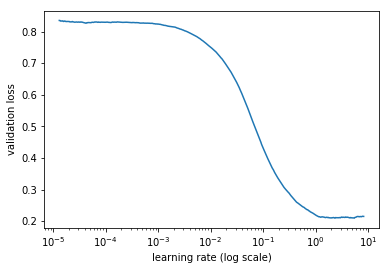

In [32]:
lrf=learn.lr_find()
learn.sched.plot()

In [33]:
# set learning rate based on the above:
lr = 0.20

In [34]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.151949   0.135612   0.880586  
    1      0.147299   0.13005    0.885774                    
    2      0.138703   0.127705   0.889467                    
    3      0.141473   0.127114   0.889797                    
    4      0.13915    0.124836   0.892                       
    5      0.135298   0.12393    0.892568                    
    6      0.135624   0.123349   0.893637                    



[array([0.12335]), 0.8936366254629077]

### Test using differential learning rates for each layer:

In [35]:
# first half, second half, last layer:
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.118587   0.109416   0.908047  
    1      0.118459   0.105341   0.911722                    
    2      0.10748    0.100372   0.915732                    
    3      0.111033   0.105431   0.913403                    
    4      0.108439   0.099254   0.916732                    
    5      0.100266   0.097337   0.918638                     
    6      0.099607   0.096179   0.919419                     



[array([0.09618]), 0.9194193786245752]

We can see the impact from using differential learning rates above. 

In [36]:
learn.save(f'{sz}')

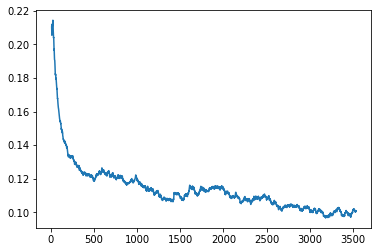

In [37]:
learn.sched.plot_loss()